In [1]:
# %% imports
# libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.modules.activation import Tanh, Sigmoid
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import sys
import csv

# local imports
import MNIST_dataloader

# %% set torches random seed
torch.random.manual_seed(0)

# %% preperations
# define parameters
# %% imports
# libraries
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# local imports
import MNIST_dataloader




# %% set torches random seed
torch.random.manual_seed(0)

# %% preperations
# define folder locations
curr_dir = os.getcwd() #os.path.dirname(os.path.realpath("__file__"))  # working dir
data_loc = os.path.join(curr_dir, r'data\Fast_MRI_Knee\MNIST\raw')  # data dir
model_path = os.path.join(curr_dir, r'LISTA.pth')  # trained model




# %% make LISTA
# ISTA parameters
# step_size = 0
# shrinkage = 0
# K = 10
# y = torch.zeros(train_loader.dataset.CleanImages.size())

class SoftThreshold(nn.Module):
    def __init__(self):
        super(SoftThreshold,self).__init__()

    def forward(self, x: torch.Tensor, thr_lambda=0.5):
        '''The commented part is an implementation of soft thresholding. But they recomment another function that propagates the gradient better.'''
        assert type(x)==torch.Tensor, "Soft Thresholding needs a tensor as input"
        self.thr = thr_lambda
        # # make |x|<self.thr = 0 
        # condition = torch.logical_or(x < self.thr, x > self.thr)
        # x = torch.where(condition, x, torch.zeros(x.size()))  # if condition is met, we take x, else we make it 0
        # # values must change as well, otherwise it will be a hard threshold
        # condition = torch.gt(x, torch.zeros(x.size()))
        # out = torch.where(condition, x + self.thr, x - self.thr)
        out = x + 1/2 * (torch.sqrt(torch.pow(x-self.thr, 2)+1) - torch.sqrt(torch.pow(x+self.thr, 2)+1))
        return out

class LISTA(nn.Module):
    def __init__(self):
        super(LISTA,self).__init__()  
        self.shrinkage = nn.parameter.Parameter(torch.ones(1))
        self.step = nn.parameter.Parameter(torch.ones(1))

        self.l1 = nn.parameter.Parameter(torch.ones(1))
        self.l2 = nn.parameter.Parameter(torch.ones(1))
        self.l3 = nn.parameter.Parameter(torch.ones(1))
        self.lf = nn.parameter.Parameter(torch.ones(1))

        self.conv1 = nn.Conv2d(1, 1, kernel_size=[7,7], padding=3, stride=1)  # 32x32->32x32
        self.soft_thr1 = SoftThreshold()
        self.conv2 = nn.Conv2d(1, 1, kernel_size=[5,5], stride=1, padding=2)  # 32x32->32x32

        self.conv3 = nn.Conv2d(1, 1, kernel_size=[7,7], padding=3, stride=1)  # 32x32->32x32
        self.soft_thr2 = SoftThreshold()
        self.conv4 = nn.Conv2d(1, 1, kernel_size=[5,5], stride=1, padding=2)  # 32x32->32x32

        self.conv5 = nn.Conv2d(1, 1, kernel_size=[7,7], padding=3, stride=1)  # 32x32->32x32
        self.soft_thr3 = SoftThreshold()
        self.conv6 = nn.Conv2d(1, 1, kernel_size=[5,5], stride=1, padding=2)  # 32x32->32x32

        self.convf = nn.Conv2d(1, 1, kernel_size=[5,5], stride=1, padding=2)  # 32x32->32x32
        self.soft_thrf = SoftThreshold()


    def forward(self,x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.soft_thr1(x1, thr_lambda=self.l1))

        x3 = self.conv3(x)
        x4 = self.conv4(self.soft_thr2(x3 + x2, thr_lambda=self.l2))

        x5 = self.conv5(x)
        x6 = self.conv6(self.soft_thr3(x5 + x4, thr_lambda=self.l3))

        out = self.convf(x)
        out = self.soft_thrf(out + x6, thr_lambda=self.lf)

        return out




# %% Start training

# parameters
batch_size = 64
epochs = 100
lr = 1e-3
loss_dict = {'train_loss':[], 'val_loss':[], 'test_loss':[]}
accu_dict = {'accu_loss':[], 'accu_loss':[], 'accu_loss':[]}

# get dataloader
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# set device
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Running on: ', device)

# create model
model = LISTA()
model = model.to(device=device)

# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-08)

# choose loss
criterion = torch.nn.MSELoss(reduction='mean')

# start the training
print("Training starts now! Good luck guuuurl!")
for e in range(epochs):
    print(f"\nTraining epoch {e}: \t")
    mia_loss = 0
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # prepare for training
        model.train(True)  
        optimizer.zero_grad()
        # move to gpu if available
        x_clean = x_clean.to(device=device, dtype=dtype)
        x_noisy = x_noisy.to(device=device, dtype=dtype)
        #label = label.to(device=device, dtype=torch.float)  # 32 bits floating reprezentation
        # forward pass
        out = model(x_noisy)
        # backpropagate loss
        loss = criterion(out, x_clean)
        loss = loss.to(torch.float16)
        loss.backward()
        mia_loss += loss.item()
        optimizer.step()
        # update loss dictionary
        loss_dict['train_loss'].append(loss.item())

    # print epoch loss
    print(f"\nEpoch training loss is {mia_loss/(batch_idx+1)}")

    with torch.no_grad():  # setting so that no backprop happens during validation
        model.eval()  # setting so that no backprop happens during validation
        vloss = 0
        for (x_clean, x_noisy, labels) in tqdm(val_loader):
            x_clean = x_clean.to(device=device, dtype=dtype)
            x_noisy = x_noisy.to(device=device, dtype=dtype)
            out = model(x_noisy)
            vloss += criterion(out, x_clean).to(torch.float16).item()
        # update loss dictionary  
        loss_dict['val_loss'].append(vloss)
        # print validation loss
        print(f"\nEpoch validation loss is {vloss/len(val_loader)}")

# save trained model
torch.save(model.state_dict(), model_path)

C:\Users\20167271\Desktop\ML for signal processing\5LSL0-GIT\Assignment 4


  0%|          | 0/844 [00:00<?, ?it/s]

Running on:  cuda
Training starts now! Good luck guuuurl!

Training epoch 0: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.12969717595249555

Epoch validation loss is 0.05507087707519531

Training epoch 1: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.04094585762204717

Epoch validation loss is 0.024648666381835938

Training epoch 2: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.01899249180798282

Epoch validation loss is 0.015325546264648438

Training epoch 3: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.014654548247278585

Epoch validation loss is 0.01351308822631836

Training epoch 4: 	


  1%|          | 6/844 [00:00<00:14, 56.70it/s]


Epoch training loss is 0.013516566199713973

Epoch validation loss is 0.012891292572021484

Training epoch 5: 	


  1%|          | 8/844 [00:00<00:11, 71.30it/s]


Epoch training loss is 0.013104976635973601

Epoch validation loss is 0.012750625610351562

Training epoch 6: 	


  1%|          | 7/844 [00:00<00:12, 68.44it/s]


Epoch training loss is 0.012925884734962789

Epoch validation loss is 0.012596607208251953

Training epoch 7: 	


  1%|          | 7/844 [00:00<00:12, 68.12it/s]


Epoch training loss is 0.012833554597827496

Epoch validation loss is 0.012470722198486328

Training epoch 8: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012776144307936537

Epoch validation loss is 0.012445449829101562

Training epoch 9: 	


  1%|          | 7/844 [00:00<00:13, 64.38it/s]


Epoch training loss is 0.012741875309514773

Epoch validation loss is 0.012534141540527344

Training epoch 10: 	


  1%|          | 7/844 [00:00<00:12, 67.85it/s]


Epoch training loss is 0.012712108015449126

Epoch validation loss is 0.012415409088134766

Training epoch 11: 	


  1%|          | 7/844 [00:00<00:12, 64.98it/s]


Epoch training loss is 0.012692347522030509

Epoch validation loss is 0.012438774108886719

Training epoch 12: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.01268062320365725

Epoch validation loss is 0.0124359130859375

Training epoch 13: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012657852534434242

Epoch validation loss is 0.012362003326416016

Training epoch 14: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012652537269049911

Epoch validation loss is 0.012404441833496094

Training epoch 15: 	


  1%|          | 6/844 [00:00<00:14, 57.28it/s]


Epoch training loss is 0.01263603101974415

Epoch validation loss is 0.01233053207397461

Training epoch 16: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012630516883886255

Epoch validation loss is 0.012413501739501953

Training epoch 17: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.0126237552877851

Epoch validation loss is 0.012329578399658203

Training epoch 18: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.01262191121612115

Epoch validation loss is 0.012316703796386719

Training epoch 19: 	


  1%|          | 7/844 [00:00<00:12, 65.10it/s]


Epoch training loss is 0.012603425301646735

Epoch validation loss is 0.012359142303466797

Training epoch 20: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012604898751064499

Epoch validation loss is 0.012406349182128906

Training epoch 21: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012606923614068054

Epoch validation loss is 0.012307167053222656

Training epoch 22: 	


  1%|          | 7/844 [00:00<00:13, 64.30it/s]


Epoch training loss is 0.012594051270688314

Epoch validation loss is 0.012316226959228516

Training epoch 23: 	


  1%|          | 7/844 [00:00<00:12, 66.46it/s]


Epoch training loss is 0.012603199312472231

Epoch validation loss is 0.012351512908935547

Training epoch 24: 	


  1%|          | 6/844 [00:00<00:13, 59.99it/s]


Epoch training loss is 0.012598815122486855

Epoch validation loss is 0.012389659881591797

Training epoch 25: 	


  1%|          | 7/844 [00:00<00:12, 66.69it/s]


Epoch training loss is 0.012598932636857598

Epoch validation loss is 0.012475967407226562

Training epoch 26: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012590995897049023

Epoch validation loss is 0.012395858764648438

Training epoch 27: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012599818514421653

Epoch validation loss is 0.012475013732910156

Training epoch 28: 	


  1%|          | 7/844 [00:00<00:12, 64.89it/s]


Epoch training loss is 0.012589215102353932

Epoch validation loss is 0.012320995330810547

Training epoch 29: 	


  1%|          | 6/844 [00:00<00:14, 59.35it/s]


Epoch training loss is 0.012595931500620187

Epoch validation loss is 0.012363910675048828

Training epoch 30: 	


  1%|          | 7/844 [00:00<00:13, 61.26it/s]


Epoch training loss is 0.012592767652177133

Epoch validation loss is 0.012409210205078125

Training epoch 31: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012601590269549764

Epoch validation loss is 0.012333869934082031

Training epoch 32: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012594024151987375

Epoch validation loss is 0.012296676635742188

Training epoch 33: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012584740516698755

Epoch validation loss is 0.012310504913330078

Training epoch 34: 	


  1%|          | 7/844 [00:00<00:12, 66.99it/s]


Epoch training loss is 0.012598227550633145

Epoch validation loss is 0.012392520904541016

Training epoch 35: 	


  1%|          | 7/844 [00:00<00:13, 61.66it/s]


Epoch training loss is 0.012599402694340565

Epoch validation loss is 0.012353897094726562

Training epoch 36: 	


  1%|          | 7/844 [00:00<00:13, 62.76it/s]


Epoch training loss is 0.012597079525626666

Epoch validation loss is 0.012294769287109375

Training epoch 37: 	


  1%|          | 6/844 [00:00<00:14, 59.59it/s]


Epoch training loss is 0.012593065957887478

Epoch validation loss is 0.012298583984375

Training epoch 38: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012602277276640254

Epoch validation loss is 0.012348651885986328

Training epoch 39: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012589423012394475

Epoch validation loss is 0.012332439422607422

Training epoch 40: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.01260137331994224

Epoch validation loss is 0.012301921844482422

Training epoch 41: 	


  1%|          | 5/844 [00:00<00:17, 48.95it/s]


Epoch training loss is 0.01259905919079532

Epoch validation loss is 0.012362480163574219

Training epoch 42: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012593436580133665

Epoch validation loss is 0.012450695037841797

Training epoch 43: 	


100%|██████████| 844/844 [00:15<00:00, 54.71it/s]



Epoch training loss is 0.012599140546898141


  0%|          | 4/844 [00:00<00:21, 38.86it/s]


Epoch validation loss is 0.012293815612792969

Training epoch 44: 	


  1%|          | 8/844 [00:00<00:11, 75.29it/s]


Epoch training loss is 0.012602937165029806

Epoch validation loss is 0.01252889633178711

Training epoch 45: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012598571054178392

Epoch validation loss is 0.012377738952636719

Training epoch 46: 	


  1%|          | 7/844 [00:00<00:12, 67.93it/s]


Epoch training loss is 0.012599746197885812

Epoch validation loss is 0.012298107147216797

Training epoch 47: 	


  1%|          | 8/844 [00:00<00:11, 73.66it/s]


Epoch training loss is 0.012600722471119668

Epoch validation loss is 0.012354850769042969

Training epoch 48: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012590679512204717

Epoch validation loss is 0.012325286865234375

Training epoch 49: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012611588030629813

Epoch validation loss is 0.012562751770019531

Training epoch 50: 	


  1%|          | 7/844 [00:00<00:12, 68.09it/s]


Epoch training loss is 0.012595795907115485

Epoch validation loss is 0.012360095977783203

Training epoch 51: 	


  1%|          | 6/844 [00:00<00:14, 59.10it/s]


Epoch training loss is 0.01260436541661267

Epoch validation loss is 0.012505054473876953

Training epoch 52: 	


  1%|          | 8/844 [00:00<00:11, 72.75it/s]


Epoch training loss is 0.012600342809306503

Epoch validation loss is 0.012354373931884766

Training epoch 53: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012606869376666174

Epoch validation loss is 0.012351036071777344

Training epoch 54: 	


  1%|          | 7/844 [00:00<00:12, 69.19it/s]


Epoch training loss is 0.012596790259483301

Epoch validation loss is 0.01244497299194336

Training epoch 55: 	


  1%|          | 7/844 [00:00<00:12, 66.74it/s]


Epoch training loss is 0.01260370552822312

Epoch validation loss is 0.01232147216796875

Training epoch 56: 	


  1%|          | 7/844 [00:00<00:12, 64.39it/s]


Epoch training loss is 0.012596844496885182

Epoch validation loss is 0.012295246124267578

Training epoch 57: 	


  1%|          | 8/844 [00:00<00:11, 71.07it/s]


Epoch training loss is 0.012608623052660323

Epoch validation loss is 0.012351036071777344

Training epoch 58: 	


  1%|          | 8/844 [00:00<00:11, 71.07it/s]


Epoch training loss is 0.012603343945543913

Epoch validation loss is 0.012306690216064453

Training epoch 59: 	


  1%|          | 7/844 [00:00<00:13, 62.49it/s]


Epoch training loss is 0.012610295372551652

Epoch validation loss is 0.012372970581054688

Training epoch 60: 	


  1%|          | 7/844 [00:00<00:12, 69.60it/s]


Epoch training loss is 0.012614751879072867

Epoch validation loss is 0.012331962585449219

Training epoch 61: 	


  1%|          | 7/844 [00:00<00:12, 66.23it/s]


Epoch training loss is 0.012602349593176096

Epoch validation loss is 0.012371540069580078

Training epoch 62: 	


  1%|          | 7/844 [00:00<00:12, 67.81it/s]


Epoch training loss is 0.012612636620399511

Epoch validation loss is 0.012296199798583984

Training epoch 63: 	


  1%|          | 7/844 [00:00<00:12, 67.27it/s]


Epoch training loss is 0.012608894239669727

Epoch validation loss is 0.012433052062988281

Training epoch 64: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012608885200102747

Epoch validation loss is 0.012292861938476562

Training epoch 65: 	


  1%|          | 7/844 [00:00<00:12, 67.22it/s]


Epoch training loss is 0.012613178994418321

Epoch validation loss is 0.012462139129638672

Training epoch 66: 	


  1%|          | 7/844 [00:00<00:12, 69.09it/s]


Epoch training loss is 0.012608803843999926

Epoch validation loss is 0.012402534484863281

Training epoch 67: 	


  1%|          | 7/844 [00:00<00:12, 69.63it/s]


Epoch training loss is 0.012606444517018105

Epoch validation loss is 0.012332916259765625

Training epoch 68: 	


  1%|          | 8/844 [00:00<00:11, 71.33it/s]


Epoch training loss is 0.012614941709979451

Epoch validation loss is 0.012318611145019531

Training epoch 69: 	


  1%|          | 7/844 [00:00<00:12, 68.22it/s]


Epoch training loss is 0.012611099894012885

Epoch validation loss is 0.012296199798583984

Training epoch 70: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012616541713334938

Epoch validation loss is 0.012331485748291016

Training epoch 71: 	


  1%|          | 8/844 [00:00<00:11, 73.61it/s]


Epoch training loss is 0.01261958804740725

Epoch validation loss is 0.01236581802368164

Training epoch 72: 	


  1%|          | 8/844 [00:00<00:11, 72.23it/s]


Epoch training loss is 0.012621007259423134

Epoch validation loss is 0.01232004165649414

Training epoch 73: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012609743958965861

Epoch validation loss is 0.012318134307861328

Training epoch 74: 	


  1%|          | 6/844 [00:00<00:14, 59.49it/s]


Epoch training loss is 0.012615809508409546

Epoch validation loss is 0.012431144714355469

Training epoch 75: 	


  1%|          | 7/844 [00:00<00:12, 66.96it/s]


Epoch training loss is 0.012620708953712789

Epoch validation loss is 0.01233053207397461

Training epoch 76: 	


  1%|          | 8/844 [00:00<00:11, 69.91it/s]


Epoch training loss is 0.012616107814119891

Epoch validation loss is 0.012412548065185547

Training epoch 77: 	


  1%|          | 7/844 [00:00<00:12, 68.08it/s]


Epoch training loss is 0.012620040025756257

Epoch validation loss is 0.012490272521972656

Training epoch 78: 	


  1%|          | 7/844 [00:00<00:13, 60.71it/s]


Epoch training loss is 0.012613929278477673

Epoch validation loss is 0.012431621551513672

Training epoch 79: 	


  1%|          | 8/844 [00:00<00:11, 71.33it/s]


Epoch training loss is 0.01262317675549837

Epoch validation loss is 0.012445926666259766

Training epoch 80: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012624614046648216

Epoch validation loss is 0.012359619140625

Training epoch 81: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.01262487619409064

Epoch validation loss is 0.012303352355957031

Training epoch 82: 	


  1%|          | 7/844 [00:00<00:12, 69.47it/s]


Epoch training loss is 0.012617011770817905

Epoch validation loss is 0.012291908264160156

Training epoch 83: 	


  1%|          | 7/844 [00:00<00:11, 69.91it/s]


Epoch training loss is 0.01261379368497297

Epoch validation loss is 0.012395858764648438

Training epoch 84: 	


  1%|          | 7/844 [00:00<00:12, 66.83it/s]


Epoch training loss is 0.01262430670137089

Epoch validation loss is 0.01233816146850586

Training epoch 85: 	


  1%|          | 8/844 [00:00<00:11, 72.28it/s]


Epoch training loss is 0.012625165460234004

Epoch validation loss is 0.01235342025756836

Training epoch 86: 	


  1%|          | 8/844 [00:00<00:11, 72.81it/s]


Epoch training loss is 0.012618223072793247

Epoch validation loss is 0.01230478286743164

Training epoch 87: 	


  1%|          | 7/844 [00:00<00:12, 69.06it/s]


Epoch training loss is 0.012627452470679984

Epoch validation loss is 0.012441158294677734

Training epoch 88: 	


  1%|          | 7/844 [00:00<00:12, 67.25it/s]


Epoch training loss is 0.012626322524807464

Epoch validation loss is 0.012343406677246094

Training epoch 89: 	


  1%|          | 7/844 [00:00<00:12, 64.45it/s]


Epoch training loss is 0.012626566593115928

Epoch validation loss is 0.012372970581054688

Training epoch 90: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012630824229163581

Epoch validation loss is 0.012341499328613281

Training epoch 91: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.01261847618066869

Epoch validation loss is 0.012363910675048828

Training epoch 92: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012629025355334531

Epoch validation loss is 0.012604713439941406

Training epoch 93: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012627045690165878

Epoch validation loss is 0.012332916259765625

Training epoch 94: 	


  1%|          | 8/844 [00:00<00:12, 69.45it/s]


Epoch training loss is 0.012627163204536619

Epoch validation loss is 0.01241302490234375

Training epoch 95: 	


  1%|          | 8/844 [00:00<00:11, 70.56it/s]


Epoch training loss is 0.012631420840584271

Epoch validation loss is 0.01244974136352539

Training epoch 96: 	


  1%|          | 7/844 [00:00<00:12, 66.82it/s]


Epoch training loss is 0.012625671675984893

Epoch validation loss is 0.012326240539550781

Training epoch 97: 	


  0%|          | 0/844 [00:00<?, ?it/s]


Epoch training loss is 0.012634431016388663

Epoch validation loss is 0.012318611145019531

Training epoch 98: 	


  1%|          | 6/844 [00:00<00:14, 58.17it/s]


Epoch training loss is 0.012632623102992633

Epoch validation loss is 0.01233530044555664

Training epoch 99: 	


100%|██████████| 844/844 [00:11<00:00, 75.88it/s]



Epoch training loss is 0.012632433272086048

Epoch validation loss is 0.012366294860839844


Lambda values found are:  Parameter containing:
tensor([0.7673], device='cuda:0', requires_grad=True) Parameter containing:
tensor([-0.4157], device='cuda:0', requires_grad=True) Parameter containing:
tensor([0.2753], device='cuda:0', requires_grad=True) Parameter containing:
tensor([-0.4241], device='cuda:0', requires_grad=True)


AttributeError: 'tuple' object has no attribute 'shape'

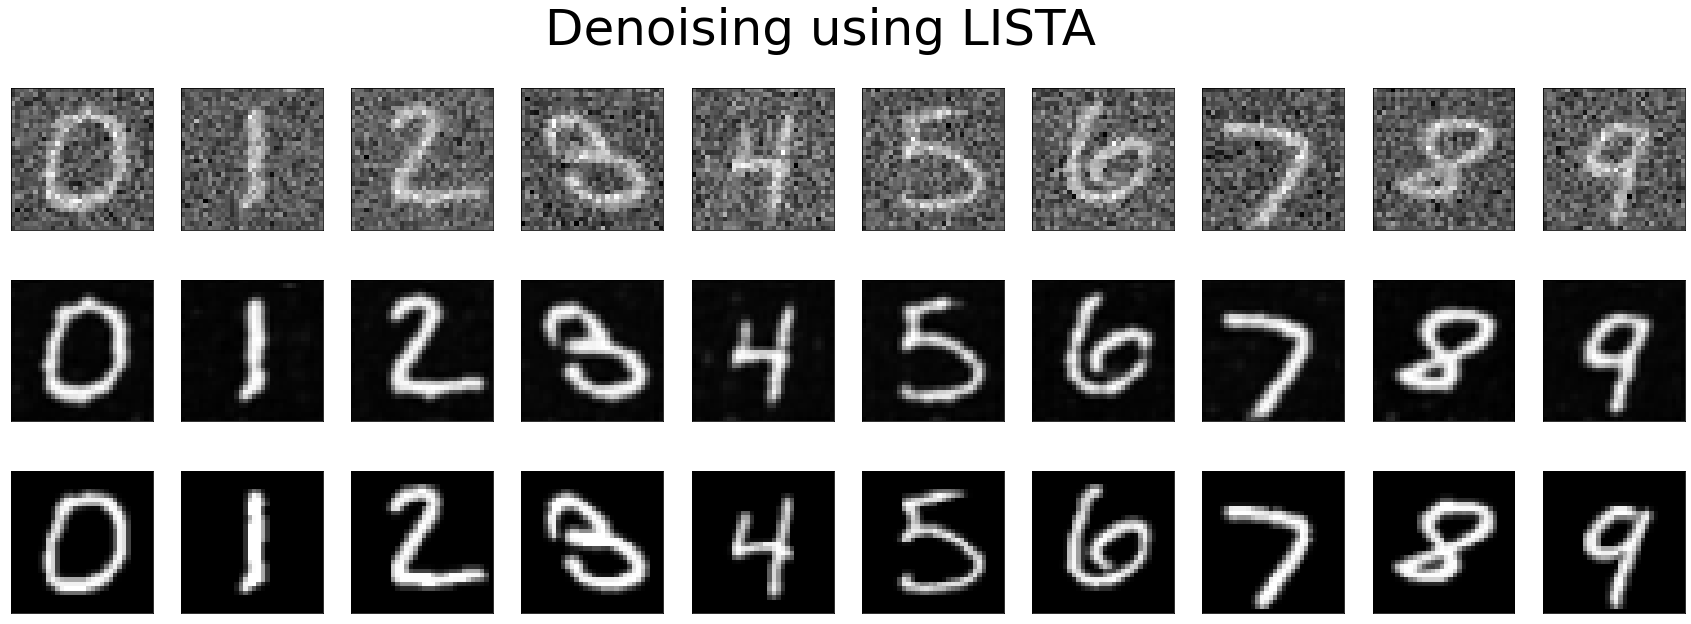

In [12]:
# Check lambda parameters
print("Lambda values found are: ", model.l1, model.l2, model.l3, model.lf)




# %% part b

# First 10 numbers
x_clean_example = test_loader.dataset.Clean_Images[0:10,:,:,:]
x_noisy_example = test_loader.dataset.Noisy_Images[0:10,:,:,:]
labels_example = test_loader.dataset.Labels[0:10]

# Plot
ax = plt.figure(figsize=(30,10))
for i in range(10):
    z = model(x_noisy_example[i,:,:,:].unsqueeze(0).to(device=device, dtype=dtype))
    z = z.to(device='cpu', dtype=dtype).detach()
    plt.subplot(3,10,i+1)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+11)
    plt.imshow(z[0,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+21)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Denoising using LISTA", fontsize=50)


In [13]:
# %% part c

# First 10 numbers
x_clean_example = test_loader.dataset.Clean_Images
x_noisy_example = test_loader.dataset.Noisy_Images

# Get MSE on test data 
with torch.no_grad():  # setting so that no backprop happens during validation
    model.eval()  # setting so that no backprop happens during validation
    test_loss = 0
    for (x_clean, x_noisy, labels) in tqdm(test_loader):
        x_clean = x_clean.to(device=device, dtype=dtype)
        x_noisy = x_noisy.to(device=device, dtype=dtype)
        out = model(x_noisy)
        test_loss += criterion(out, x_clean).to(torch.float16).item()
    # update loss dictionary  
    loss_dict['test_loss'].append(vloss)
    # print validation loss
    print(f"\nTest loss is {test_loss/len(test_loader)}")


100%|██████████| 157/157 [00:01<00:00, 88.76it/s] 


Test loss is 0.012435086973153861
